# Requirements

In [21]:
# Add as many imports as you need.

# Laboratory Exercise - Run Mode (8 points)

## Introduction
This laboratory assignment's primary objective is to fine-tune a pre-trained language model for binary classification on a dataset consisting of wine reviews. The dataset contains two attributes: **description** and **points**. The description is a brief text describing the wine and the points represent a quality metric ranging from 1 to 100. If some wine has at least 90 points it is considered **exceptional**. Your task involves predicting if some wine is **exceptional** based on its review.

## The Wine Reviews Dataset

Load the dataset using the `datasets` library.

In [6]:
import pandas as pd
from sklearn.linear_model import LogisticRegression

# Write your code here. Add as many boxes as you need.
df = pd.read_csv("./wine-reviews.csv")

In [7]:
df

,description,points
0,"Translucent in color, silky in the mouth, this...",85
1,"On the palate, this wine is rich and complex, ...",92
2,The producer blends 57% Chardonnay from the Ma...,92
3,"Pure Baga in all its glory, packed with dry an...",93
4,Think of Subsídio as a contribution rather tha...,89
...,...,...
9995,"From the folks at Merryvale, this is a blend o...",92
9996,"An easy, versatile food wine or cocktail sippe...",84
9997,Black-fruit aromas blend nicely into chocolate...,93
9998,"This combines 61% Cabernet Sauvignon, 14% Syra...",90


In [8]:
df["target"] = df["points"]

In [9]:
df

,description,points,target
0,"Translucent in color, silky in the mouth, this...",85,85
1,"On the palate, this wine is rich and complex, ...",92,92
2,The producer blends 57% Chardonnay from the Ma...,92,92
3,"Pure Baga in all its glory, packed with dry an...",93,93
4,Think of Subsídio as a contribution rather tha...,89,89
...,...,...,...
9995,"From the folks at Merryvale, this is a blend o...",92,92
9996,"An easy, versatile food wine or cocktail sippe...",84,84
9997,Black-fruit aromas blend nicely into chocolate...,93,93
9998,"This combines 61% Cabernet Sauvignon, 14% Syra...",90,90


In [10]:
df["target"]=df["target"].apply(lambda x:1 if x>=90 else 0)

In [27]:
df

,description,points,target
0,"Translucent in color, silky in the mouth, this...",85,0
1,"On the palate, this wine is rich and complex, ...",92,1
2,The producer blends 57% Chardonnay from the Ma...,92,1
3,"Pure Baga in all its glory, packed with dry an...",93,1
4,Think of Subsídio as a contribution rather tha...,89,0
...,...,...,...
9995,"From the folks at Merryvale, this is a blend o...",92,1
9996,"An easy, versatile food wine or cocktail sippe...",84,0
9997,Black-fruit aromas blend nicely into chocolate...,93,1
9998,"This combines 61% Cabernet Sauvignon, 14% Syra...",90,1


In [28]:
from datasets import Dataset

dataset = Dataset.from_pandas(df[:500].drop(columns=["points"],axis=1))

In [29]:
print(dataset)

Dataset({
    features: ['description', 'target'],
    num_rows: 500
})


## Target Extraction
Extract the target **exceptional** for each wine review. If some wine has at least 90 points it is considered **exceptional**.

In [30]:
# Write your code here. Add as many boxes as you need.


## Dataset Splitting
Partition the dataset into training and testing sets with an 80:20 ratio.


In [31]:
# Write your code here. Add as many boxes as you need.
dataset = dataset.train_test_split(test_size=0.2)
dataset


DatasetDict({
    train: Dataset({
        features: ['description', 'target'],
        num_rows: 400
    })
    test: Dataset({
        features: ['description', 'target'],
        num_rows: 100
    })
})

In [32]:

dataset = dataset.rename_column("target", "label")
dataset = dataset.rename_column("description", "text")
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 400
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 100
    })
})

## Tokenization
Tokenize the texts using the `AutoTokenizer` class.

In [33]:
# Write your code here. Add as many boxes as you need.
from transformers import AutoTokenizer

checkpoint = "google-bert/bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [34]:
def tokenize(sample):
    return tokenizer(sample["text"], truncation=True)

In [35]:
tokenized_dataset = dataset.map(tokenize, batched=True)


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

In [43]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [44]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 400
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 100
    })
})

## Fine-tuning a Pre-trained Language Model for Classification
Fine-tune a pre-trained language model for classification on the given dataset.

Define the model using the `AutoModelForSequenceClassification` class.

In [45]:
# Write your code here. Add as many boxes as you need.
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="trainer",
    eval_strategy="epoch",
    per_device_train_batch_size=16,  # batch size for training
    per_device_eval_batch_size=16,  # batch size for evaluation
    metric_for_best_model="f1",
    num_train_epochs=3,
)

In [46]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [47]:
import evaluate
import numpy as np

metric = evaluate.load("f1")

In [48]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels, average="weighted")

In [49]:
from transformers import Trainer

trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    compute_metrics=compute_metrics,
    data_collator=data_collator,
)

Define the traning parameters using the `TrainingArguments` class.

In [37]:
# Write your code here. Add as many boxes as you need.

Define the training using the `Trainer` class.

In [51]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

# Write your code here. Add as many boxes as you need.
model.to(device)


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

Fine-tune (train) the pre-trained lanugage model.

In [52]:
# Write your code here. Add as many boxes as you need.
trainer.train()


Epoch,Training Loss,Validation Loss,F1
1,No log,0.575782,0.724288
2,No log,0.523378,0.780265
3,No log,0.517555,0.800241


TrainOutput(global_step=75, training_loss=0.46284459431966146, metrics={'train_runtime': 36.5629, 'train_samples_per_second': 32.82, 'train_steps_per_second': 2.051, 'total_flos': 58895765298240.0, 'train_loss': 0.46284459431966146, 'epoch': 3.0})

Use the trained model to make predictions for the test set.

In [40]:
# Write your code here. Add as many boxes as you need.

Assess the performance of the model by using different metrics provided by the `scikit-learn` library.

In [53]:
# Write your code here. Add as many boxes as you need.
predictions = trainer.predict(tokenized_dataset["test"])
logits, labels = predictions.predictions, predictions.label_ids
preds = np.argmax(logits, axis=-1)

In [54]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
print(classification_report(labels, preds))

              precision    recall  f1-score   support

           0       0.77      0.80      0.79        46
           1       0.83      0.80      0.81        54

    accuracy                           0.80       100
   macro avg       0.80      0.80      0.80       100
weighted avg       0.80      0.80      0.80       100



Text(0.5, 1.0, 'Confusion Matrix')

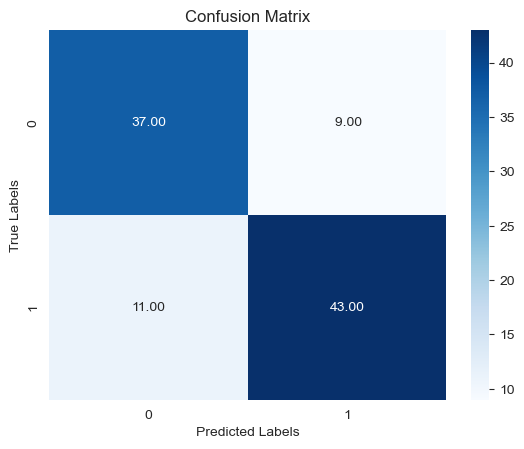

In [55]:
sns.heatmap(confusion_matrix(labels, preds), annot=True, fmt="5.2f", cmap="Blues")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")

# Laboratory Exercise - Bonus Task (+ 2 points)

Implement a simple machine learning pipeline to classify wine reviews as **exceptional** or not. Use TF-IDF vectorization to convert text into numerical features and train a logistic regression. Split the dataset into training and testing sets, fit the pipeline on the training data, and evaluate its performance using metrics such as precision, recall, and F1-score. Analyze the texts to find the most influential words or phrases associated with the **exceptional** wines. Use the coefficients from the logistic regression trained on TF-IDF features to identify the top positive and negative keywords for **exceptional** wines. Present these keywords in a simple table or visualization (e.g., bar chart).

In [56]:
# Write your code here. Add as many boxes as you need.

In [11]:
df

,description,points,target
0,"Translucent in color, silky in the mouth, this...",85,0
1,"On the palate, this wine is rich and complex, ...",92,1
2,The producer blends 57% Chardonnay from the Ma...,92,1
3,"Pure Baga in all its glory, packed with dry an...",93,1
4,Think of Subsídio as a contribution rather tha...,89,0
...,...,...,...
9995,"From the folks at Merryvale, this is a blend o...",92,1
9996,"An easy, versatile food wine or cocktail sippe...",84,0
9997,Black-fruit aromas blend nicely into chocolate...,93,1
9998,"This combines 61% Cabernet Sauvignon, 14% Syra...",90,1


In [12]:

from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(df['description'],  df['target'], test_size=0.2)

In [13]:

from collections import Counter

print(f"Training class distributions summary: {Counter(Y_train)}")
print(f"Test class distributions summary: {Counter(Y_test)}")

Training class distributions summary: Counter({0: 4005, 1: 3995})
Test class distributions summary: Counter({1: 1005, 0: 995})


In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline

model = make_pipeline(TfidfVectorizer(), LogisticRegression())
model.fit(X_train, Y_train)

y_pred = model.predict(X_test)

In [15]:

from imblearn.metrics import classification_report_imbalanced

print(classification_report_imbalanced(Y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.82      0.76      0.83      0.79      0.80      0.63       995
          1       0.78      0.83      0.76      0.81      0.80      0.64      1005

avg / total       0.80      0.80      0.80      0.80      0.80      0.64      2000



In [16]:
from imblearn.pipeline import make_pipeline as make_pipeline_imb
from imblearn.under_sampling import RandomUnderSampler

model = make_pipeline_imb(TfidfVectorizer(), RandomUnderSampler(), MultinomialNB())
model.fit(X_train, Y_train)

y_pred = model.predict(X_test)

In [17]:
print(classification_report_imbalanced(Y_test, y_pred))


                   pre       rec       spe        f1       geo       iba       sup

          0       0.82      0.74      0.84      0.78      0.79      0.62       995
          1       0.77      0.84      0.74      0.80      0.79      0.63      1005

avg / total       0.79      0.79      0.79      0.79      0.79      0.62      2000

